In [65]:
import pandas as pd
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost as xgb
import numpy as np
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
import joblib

In [66]:
data =pd.read_csv('../data/processed/mdt.csv', encoding='Latin1', index_col='id')
selected_features = pd.read_csv('../data/processed/selected_features.csv')['0'].to_list()
fraud_pipeline = joblib.load('../models/feature_engineering_pipeline.joblib')
print(selected_features)
print(data.shape)
data.head()

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'annual_inc', 'addr_state', 'dti', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt']
(38480, 27)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,repay_fail
id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,36 months,0.00,0.00,< 1 year,RENT,0.0,Not Verified,...,0.0,0.0,0.0,1.0,0.000000,0.00,0.00,0.00,0.00,1
545583,2500.0,2500.0,2500.0,36 months,13.98,85.42,4 years,RENT,20004.0,Not Verified,...,0.0,981.0,21.3,10.0,3075.291779,3075.29,2500.00,575.29,90.85,0
532101,5000.0,5000.0,5000.0,36 months,15.95,175.67,4 years,RENT,59000.0,Not Verified,...,0.0,18773.0,99.9,15.0,2948.760000,2948.76,1909.02,873.81,175.67,1
877788,7000.0,7000.0,7000.0,36 months,9.91,225.58,10+ years,MORTGAGE,53796.0,Not Verified,...,0.0,3269.0,47.2,20.0,8082.391880,8082.39,7000.00,1082.39,1550.27,0
875406,2000.0,2000.0,2000.0,36 months,5.42,60.32,10+ years,RENT,30000.0,Not Verified,...,0.0,0.0,0.0,15.0,2161.663244,2161.66,2000.00,161.66,53.12,0


In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['repay_fail'], axis=1), # predictive variables
    data['repay_fail'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((34632, 26), (3848, 26))

In [68]:
X_train_transformed = fraud_pipeline.transform(X_train)
X_test_transformed = fraud_pipeline.transform(X_test)

In [69]:
from sklearn import model_selection
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    dfs = []
    models = [
            ('LogReg', LogisticRegression()), 
            ('RF', RandomForestClassifier()),
            ('KNN', KNeighborsClassifier()),
           # ('SVM', SVC()), 
            ('GNB', GaussianNB()),
            ('XGB', XGBClassifier(objective= "binary:logistic",eval_metric = "mlogloss",use_label_encoder=False))
            ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['No Fraude', 'Fraude']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)[:, 1]

        # Calcula el ROC-AUC con diferentes umbrales
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)

        # Encuentra el umbral óptimo que maximiza el AUC
        optimal_threshold_index = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_threshold_index]

        y_pred = (y_prob >= optimal_threshold).astype(int)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        this_df['optimize_threshold'] = optimal_threshold
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final

In [70]:
data = run_exps(X_train_transformed, y_train.values.ravel(), X_test_transformed, y_test.values.ravel())

In [ ]:
bootstraps = []

for model in list(set(data.model.values)):
    model_df = data.loc[data.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

In [ ]:
bootstrap_df[bootstrap_df['test_roc_auc'] == bootstrap_df['test_roc_auc'].max()]

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model,optimize_threshold
30,1.987492,0.056447,0.999856,0.999856,0.999856,0.999856,1.0,RF,0.54
36,1.987492,0.056447,0.999856,0.999856,0.999856,0.999856,1.0,RF,0.54
37,1.987492,0.056447,0.999856,0.999856,0.999856,0.999856,1.0,RF,0.54
40,1.987492,0.056447,0.999856,0.999856,0.999856,0.999856,1.0,RF,0.54
43,1.987492,0.056447,0.999856,0.999856,0.999856,0.999856,1.0,RF,0.54
48,1.987492,0.056447,0.999856,0.999856,0.999856,0.999856,1.0,RF,0.54
52,1.987492,0.056447,0.999856,0.999856,0.999856,0.999856,1.0,RF,0.54


Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

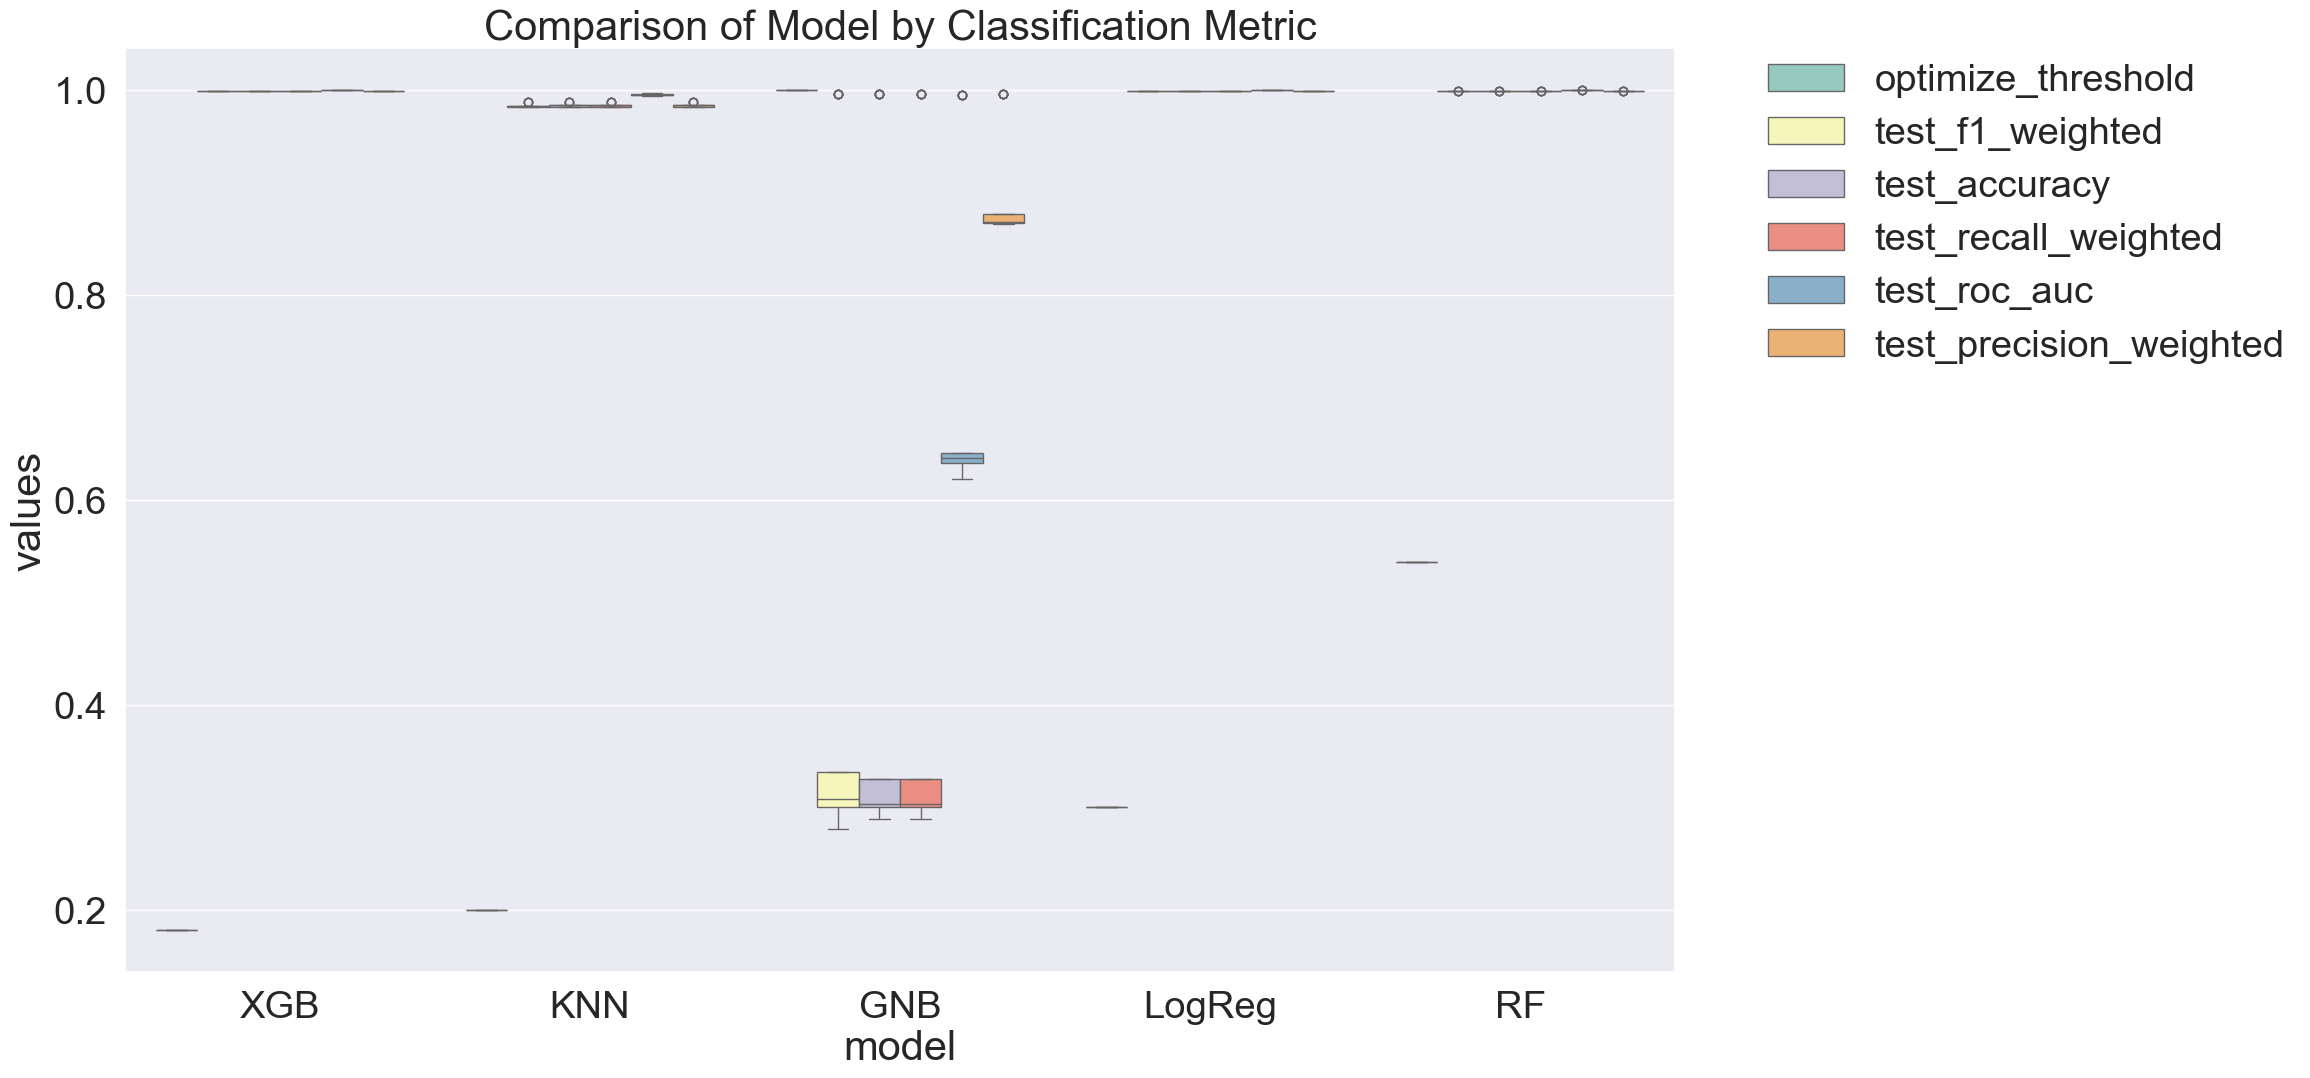

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

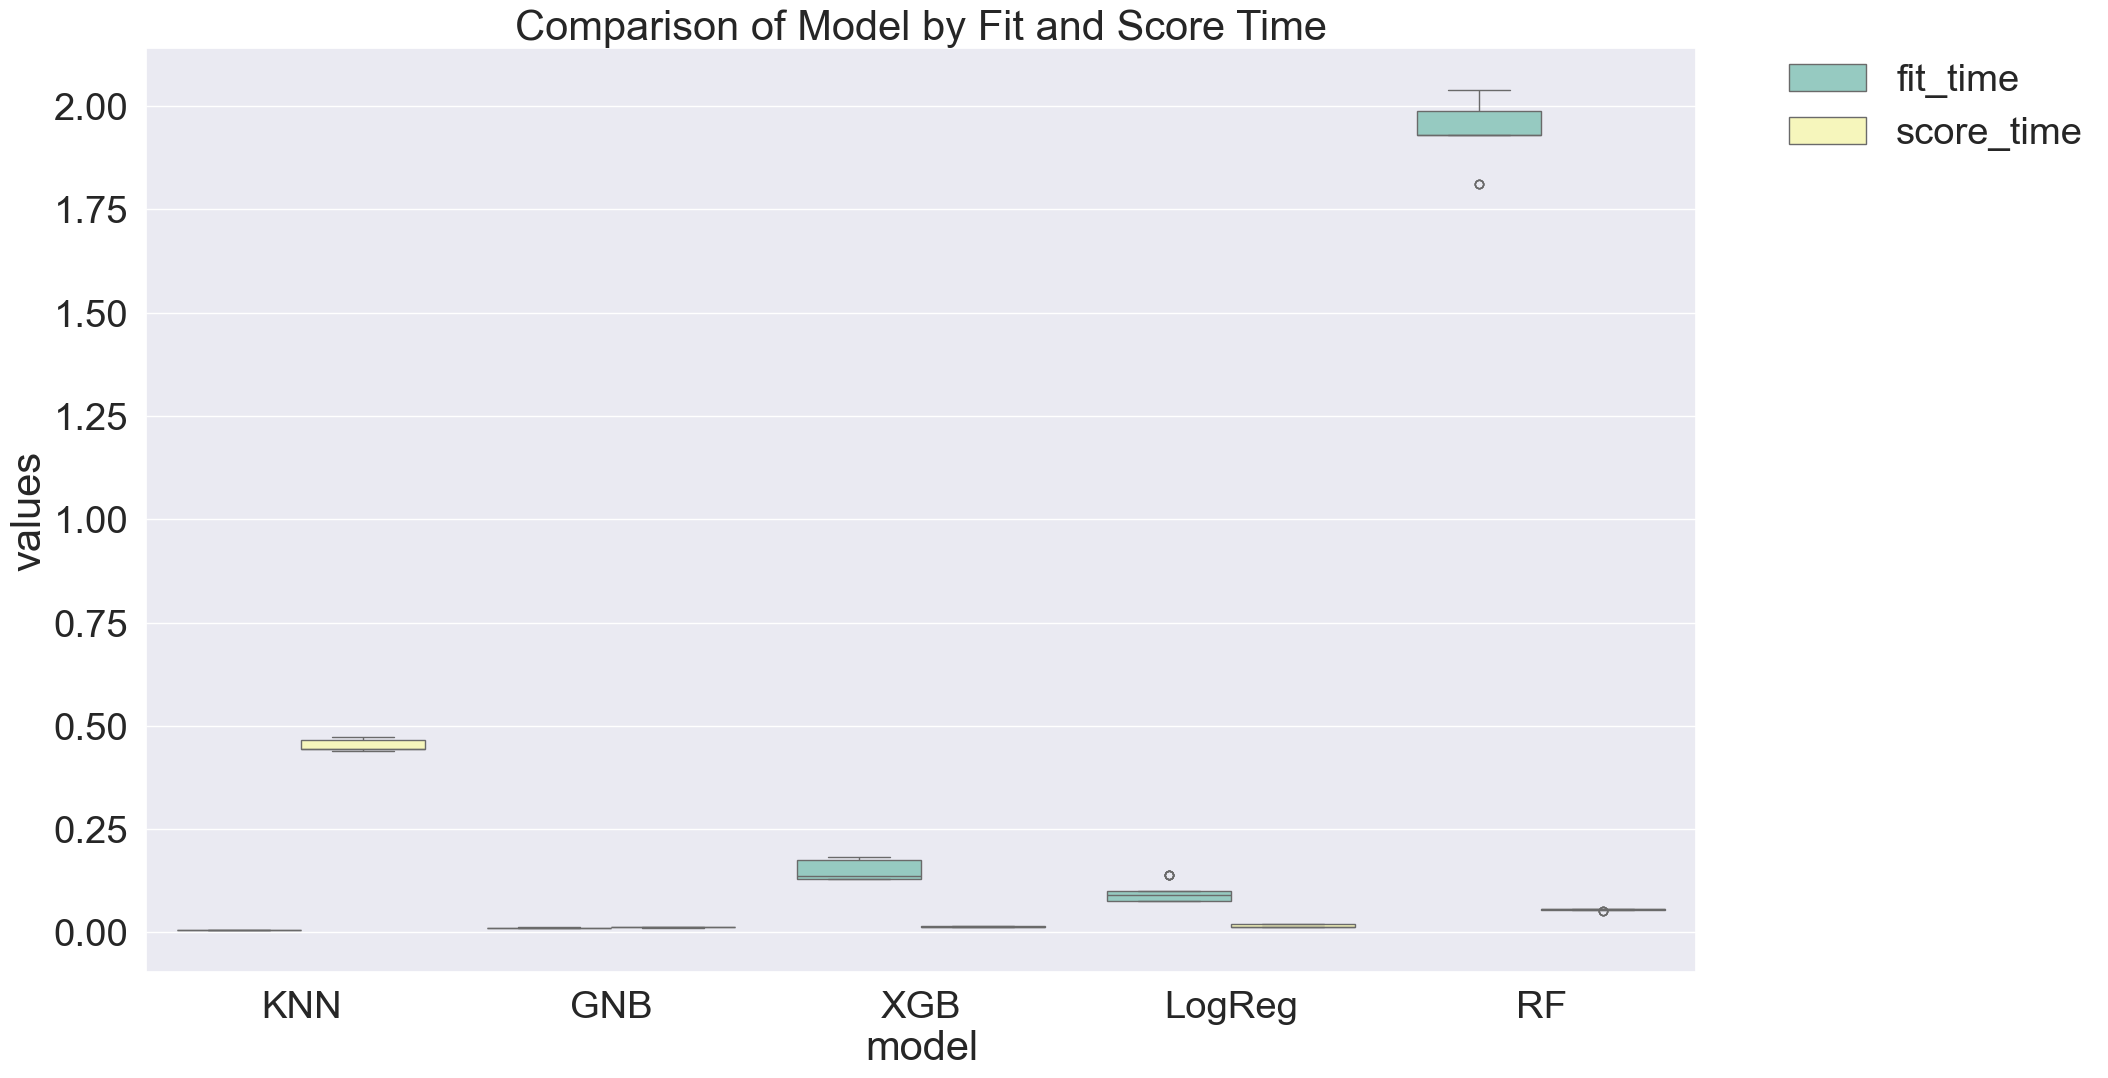

In [ ]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')

Me quedo con el XGB

In [ ]:
clf = XGBClassifier()
clf.fit(X_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
preds_test = clf.predict_proba(X_test_transformed)[:, 1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, preds_test)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

y_pred = (preds_test >= optimal_threshold).astype(int)

In [ ]:
optimal_threshold

0.18048355

In [ ]:
confusion_matrix(y_test, y_pred)

array([[3239,    1],
       [   0,  608]])

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3240
           1       1.00      1.00      1.00       608

    accuracy                           1.00      3848
   macro avg       1.00      1.00      1.00      3848
weighted avg       1.00      1.00      1.00      3848



In [ ]:
roc_auc_score(y_test, preds_test)

0.9999984770955166

In [ ]:
fraud_pipeline.steps.append(('model', clf))

In [ ]:
joblib.dump(fraud_pipeline, '../models/final_pipeline.joblib')

['../models/final_pipeline.joblib']

In [ ]:
selected_features

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'annual_inc',
 'loan_status',
 'purpose',
 'addr_state',
 'dti',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'revol_bal',
 'revol_util',
 'total_acc',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'last_pymnt_amnt']

In [ ]:
X_train.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'last_pymnt_amnt'],
      dtype='object')

In [ ]:
data.columns

Index(['fit_time', 'score_time', 'test_accuracy', 'test_precision_weighted',
       'test_recall_weighted', 'test_f1_weighted', 'test_roc_auc', 'model',
       'optimize_threshold'],
      dtype='object')

In [ ]:
fraud_pipeline.predict_proba(X_test)

array([[9.9997061e-01, 2.9359151e-05],
       [1.5294552e-04, 9.9984705e-01],
       [1.1885166e-04, 9.9988115e-01],
       ...,
       [2.6684999e-04, 9.9973315e-01],
       [9.9998927e-01, 1.0704510e-05],
       [2.1725893e-04, 9.9978274e-01]], dtype=float32)

In [ ]:
importances = clf.feature_importances_


In [ ]:
importances

array([2.0640995e-04, 0.0000000e+00, 2.5126265e-04, 0.0000000e+00,
       1.0418167e-03, 2.0659923e-04, 1.6516371e-04, 2.9909777e-04,
       2.0910918e-03, 2.0194238e-04, 9.9017197e-01, 6.1244750e-04,
       1.9776011e-04, 6.8714895e-04, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 8.2382932e-05, 0.0000000e+00, 4.4303585e-04,
       2.5245975e-04, 2.3688574e-04, 0.0000000e+00, 4.3116964e-04,
       1.8385438e-04, 3.6541221e-04, 8.3720231e-05, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.7883327e-03,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

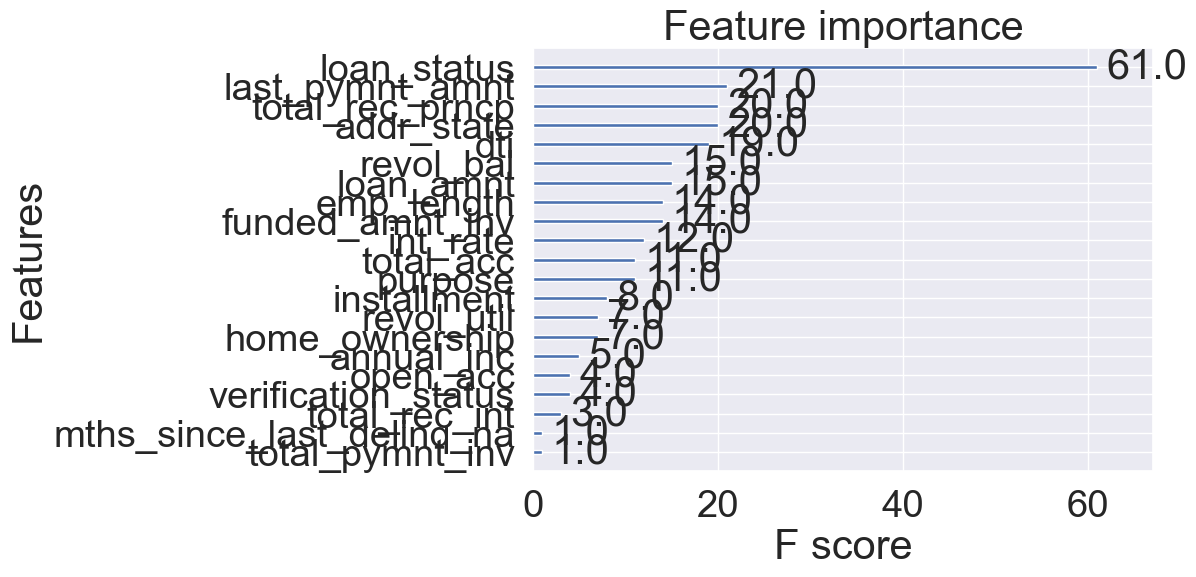

In [ ]:
xgb.plot_importance(clf)

In [ ]:
data

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model,optimize_threshold
0,0.117353,0.015432,0.999423,0.999422,0.999423,0.999422,0.999999,LogReg,0.448361
1,0.073753,0.014759,0.999711,0.999711,0.999711,0.999711,1.000000,LogReg,0.448361
2,0.082122,0.009561,0.999134,0.999139,0.999134,0.999135,0.999997,LogReg,0.448361
3,0.075678,0.013839,0.999278,0.999278,0.999278,0.999278,0.999999,LogReg,0.448361
4,0.068600,0.009873,0.999567,0.999567,0.999567,0.999567,1.000000,LogReg,0.448361
5,2.120146,0.057188,0.999423,0.999423,0.999423,0.999422,1.000000,RF,0.390000
6,2.086835,0.055445,0.999711,0.999712,0.999711,0.999711,1.000000,RF,0.390000
7,1.939607,0.052099,0.998989,0.998991,0.998989,0.998990,0.999997,RF,0.390000
8,2.165950,0.054550,0.999567,0.999567,0.999567,0.999567,0.999999,RF,0.390000
9,1.912362,0.050298,0.999856,0.999856,0.999856,0.999856,1.000000,RF,0.390000


In [ ]:
data['last_pymnt_d']

id
2          Jan-07
545583     Jul-13
532101     Nov-11
877788     Mar-14
875406     Feb-14
            ...  
849205     Aug-14
852914     Sep-14
519553     Jun-13
825638     Aug-14
1029847    Dec-14
Name: last_pymnt_d, Length: 38480, dtype: object